## 2D Ising Model Monte Carlo Simulation

With code from Lauren Hayward Sierens/PSI, Juan Carrasquilla, Estelle Inack, Giacomo Torlai, and Roger Melko. Adapted from Machine Learning in Condensed Matter Physics 2019, University of the Basque Country Summer Course

Our aim is to study the phase transitions in the 2D Ising model

$$
H_{\text{Ising}}=-J\sum_{\langle ij\rangle}\sigma_{i}\sigma_{j},
$$

where $\sigma_{i}=\pm1$, $J$ is the exchange constant and the sum runs over all nearest neighbors. We resort to using a square lattice with periodic boundary conditions. 

The below code implements Monte Carlo (MC) methods that estimate $T_{C}$ by calculating relevant observables

The main purpose of this code is to generate the necessary training data (i.e. spin configurations $\cal{D}=\{{\bf{x}}_{l}\}_{l=1}^{\cal{N}}$) that will then be fed into the notebook `2D_Ising_RBM.ipynb` in order to train a Restricted Boltzmann Machine (RBM), a type of neural network, to learn the distribution of spin configurations of the 2D Ising model at a given temperature.

The set of spin configurations $\cal{D}$ is not random, but should be produced via importance sampling, i.e. Markov chain MC, as we'll do below.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import random
import time

Initially, choose to work with an $N=4\times4=16$ site system. This can be changed to accomodate larger system sizes.

In [2]:
### Input parameters: ###
T_list = np.linspace(5.0,0.5,10) #temperature list
L = 4                            #linear size of the lattice
N_spins = L**2                   #total number of spins
J = 1                            #coupling parameter

We know that in the thermodynamic limit, the critical temperature is $T_{C}\approx2.269$.

In [3]:
### Critical temperature: ###
Tc = 2.0/np.log(1.0 + np.sqrt(2))*J  #T/J ~ 2.269

Setting thermalization and measurement MC sweep parameters

In [4]:
## Monte Carlo parameters: ###
n_eqSweeps = 1000   #number of equilibration sweeps
n_measSweeps = 10000  #number of measurement sweeps

Optional annimation settings (Default is off, i.e. commented out)

In [5]:
### Parameters needed to show animation of spin configurations: ###
animate = True
bw_cmap = colors.ListedColormap(['black', 'white'])

A local directory is created to store the Energy and Magnetization that will be calculated corresponding to a configuration of spins for a given measurement sweep.

In [6]:
### Create a directory where measured observables will be stored: ###
results_dir = 'Data'
if not(os.path.isdir(results_dir)):
    os.mkdir(results_dir)

We initialize the spins to a random configuration for the first MC sweep.

e.g. ${\bf{x}}_{1}=(1,0,1,1,1,0,0,1,0,0,1,0,0,1,1,1)$,

where the place order gives us information on the site location for a given Ising spin value. 

In [7]:
### Initially, the spins are in a random state (a high-T phase): ###
spins = np.zeros(N_spins,dtype=np.int)
for i in range(N_spins):
    spins[i] = 2*random.randint(0,1) - 1 #either +1 or -1


A means of obtaining the Ising spin value corresponding to the four nearest neighbors for a given site, given periodic boundary conditions.

In [8]:
### Store each spin's four nearest neighbours in a neighbours array (using periodic boundary conditions): ###
neighbours = np.zeros((N_spins,4),dtype=np.int)
for i in range(N_spins):
    #neighbour to the right:
    neighbours[i,0]=i+1
    if i%L==(L-1):
        neighbours[i,0]=i+1-L

    #upwards neighbour:
    neighbours[i,1]=i+L
    if i >= (N_spins-L):
        neighbours[i,1]=i+L-N_spins

    #neighbour to the left:
    neighbours[i,2]=i-1
    if i%L==0:
        neighbours[i,2]=i-1+L

    #downwards neighbour:
    neighbours[i,3]=i-L
    if i <= L:
        neighbours[i,3]=i-L+N_spins

Functions that calculate the Energy and magnetization for a given configuration of spins.

The Energy is calcuated according to the form of the Ising Hamiltonian shown above. 

The Magnetization is just $M = \sum_{i}\sigma_{i}$.

In [9]:
### Function to calculate the total energy ###
def getEnergy():
    currEnergy = 0
    for i in range(N_spins):
        currEnergy += -J*( spins[i]*spins[neighbours[i,0]] + spins[i]*spins[neighbours[i,1]] )
    return currEnergy
#end of getEnergy() function



### Function to calculate the total magnetization ###
def getMag():
    return np.sum(spins)
#end of getMag() function

A function that performs a single MC sweep. Beginning with an initial spin configuration ${\bf{x}}_{1}$, we obtain the remainder of the set $\cal{D}$ via a transition probability $T$ such that

$$
T({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})\geq0\qquad\text{and}\qquad\sum_{m}T({\bf{x}}_{l}\rightarrow{\bf{x}}_{m})=1.
$$

which satisfies both detailed balance and ergodicity.

i.e. to ensure that we are sampling from the correct probability distribution $P({\bf{x}})$ (where $\mathbb{E}[\cal{O}]=\langle\cal{O}\rangle=\frac{1}{\cal{Z}}\langle\psi|\hat{\cal{O}}|\psi\rangle=\sum_{{\bf{x}}}P({\bf{x}})\cal{O}_{{\bf{x}}})$, 

$$
P({\bf{x}}_{l})T({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})=P({\bf{x}}_{l+1})T({\bf{x}}_{l+1}\rightarrow{\bf{x}}_{l})
$$
or
$$
\frac{T({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})}{T({\bf{x}}_{l+1}\rightarrow{\bf{x}}_{l})}=\frac{P({\bf{x}}_{l+1})}{P({\bf{x}}_{l})}.
$$

To achieve this we start by splitting the transition probability, $T$, into two parts: a selection probability, $g$, and an acceptance ratio, $A$, as follows

$$
T({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})=g({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})A({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1}),
$$

and propose as an update to a given spin configuration: $x_{i}\rightarrow-x_{i}$ (where $x_{i}\in{\bf{x}}_{l}$, for $1\leq i\leq N$).

Then the selection probability $g({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})=\frac{1}{N}$, $\forall\,{\bf{x}}_{l},{\bf{x}}_{l+1}$, and

$$
\frac{T({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})}{T({\bf{x}}_{l+1}\rightarrow{\bf{x}}_{l})}=\frac{\frac{1}{N}A({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})}{\frac{1}{N}A({\bf{x}}_{l+1}\rightarrow{\bf{x}}_{l})}=\frac{P({\bf{x}}_{l+1})}{P({\bf{x}}_{l})},
$$

suggesting 

$$
\frac{A({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})}{A({\bf{x}}_{l+1}\rightarrow{\bf{x}}_{l})}=e^{-\beta(E_{l+1}-E_{l})},
$$

for $P$ given as a Boltzmann distribution, where $\beta=\frac{1}{T}$, of course.

For $E_{l}<E_{l+1}$, we thus choose ${A({\bf{x}}_{l+1}\rightarrow{\bf{x}}_{l})}=1$ such that $A({\bf{x}}_{l}\rightarrow{\bf{x}}_{l+1})=e^{-\beta(E_{l+1}-E_{l})}$, and the metropolis algorithm will thus flip a single spin (i.e. update the spin configuration of the lattice) whenever $(E_{l+1}-E_{l})\leq0$ or $e^{-\beta(E_{l+1}-E_{l})}>r$, for some random $0\leq r<1$. 

In [10]:
### Function to perform one Monte Carlo sweep ###
def sweep():
  #do one sweep (N_spins single-spin flips):
  for i in range(N_spins):
    #randomly choose which spin to consider flipping:
    site = random.randint(0,N_spins-1)
    
    #calculate the change in energy for the proposed move:
    E_init = getEnergy()
    spins[site] = -spins[site] #flip the spin before calculating E_final
    E_final = getEnergy()
    spins[site] = -spins[site] #flip the spin back since we might not accept the move
    deltaE = E_final - E_init

    if (deltaE <= 0) or (random.random() < np.exp(-deltaE/T)):  #Metropolis algorithm
      #flip the spin:
      spins[site] = -spins[site]
  #end loop over i
#end of sweep() function


Loop over a series of temperatures $T$ while performing Monte Carlo updates. Calculates Energy and Magnetization for each new configuration in the equilibration sweep and stores these results to an external file in the local directory created earlier. Code can be adjusted to store spin configurations instead of each configuration's Energy  and Magnetization, as would be done to produce training data that is later fed to the RBM notebook. Option to print a graphic depicting the current spin configuration is available but has been commented out in order to speed up the caluclation process.

In [11]:
#################################################################################
########## Loop over all temperatures and perform Monte Carlo updates: ##########
#################################################################################
t1 = time.clock() #for timing
for T in T_list:
    print('\nT = %f' %T)
  
  #open a file where observables will be recorded:
    fileName         = '%s/ising2d_L%d_T%.4f.txt' %(results_dir,L,T)
    file_observables = open(fileName, 'w')
  
  #equilibration sweeps:
    for i in range(n_eqSweeps):
        sweep()

    #start doing measurements:
    for i in range(n_measSweeps):
        sweep()

        #Write the observables to file:
        energy = getEnergy()
        mag    = getMag()
        file_observables.write('%d \t %.8f \t %.8f \n' %(i, energy, mag))

#         if animate:
#             #Display the current spin configuration:
#             plt.clf()
#             plt.imshow( spins.reshape((L,L)), cmap=bw_cmap, norm=colors.BoundaryNorm([-1,0,1], bw_cmap.N), interpolation='nearest' )
#             plt.xticks([])
#             plt.yticks([])
#             plt.title('%d x %d Ising model, T = %.3f' %(L,L,T))
#             plt.pause(0.01)
#             #end if

        if (i+1)%1000==0:
            print('  %d sweeps complete' %(i+1))
        #end loop over i

    file_observables.close()
    #end loop over temperature
    
t2 = time.clock()
print('Elapsed time: %f seconds' %(t2-t1))

/Users/complexphenom/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.



T = 5.000000
  1000 sweeps complete
  2000 sweeps complete
  3000 sweeps complete
  4000 sweeps complete
  5000 sweeps complete
  6000 sweeps complete
  7000 sweeps complete
  8000 sweeps complete
  9000 sweeps complete
  10000 sweeps complete

T = 4.500000
  1000 sweeps complete
  2000 sweeps complete
  3000 sweeps complete
  4000 sweeps complete
  5000 sweeps complete
  6000 sweeps complete
  7000 sweeps complete
  8000 sweeps complete
  9000 sweeps complete
  10000 sweeps complete

T = 4.000000
  1000 sweeps complete
  2000 sweeps complete
  3000 sweeps complete
  4000 sweeps complete
  5000 sweeps complete
  6000 sweeps complete
  7000 sweeps complete
  8000 sweeps complete
  9000 sweeps complete
  10000 sweeps complete

T = 3.500000
  1000 sweeps complete
  2000 sweeps complete
  3000 sweeps complete
  4000 sweeps complete
  5000 sweeps complete
  6000 sweeps complete
  7000 sweeps complete
  8000 sweeps complete
  9000 sweeps complete
  10000 sweeps complete

T = 3.000000
  1000

/Users/complexphenom/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


## Plot Observables from MC

In [12]:
### Observables to plot as a function of temperature: ###
energy   = np.zeros(len(T_list))
mag      = np.zeros(len(T_list))
specHeat = np.zeros(len(T_list))
susc     = np.zeros(len(T_list))

We import the set of Energies and Magnetizations calculated above for every sweep at given $T$'s and obtain the mean Energy and mean Magnetization for thease. Because there is no spontaneous symmetry breaking for finite sized lattices ($\langle M\rangle=0,\,\forall\,T$), we instead use $\langle |M|\rangle$ in our calculation of $\chi$

$$
C_{V}=\frac{\langle E^{2}\rangle-\langle E\rangle^{2}}{T^{2}},\qquad \chi=\frac{\langle M^{2}\rangle-\langle |M|\rangle^{2}}{T}.
$$

In [13]:
### Loop to read in data for each temperature: ###
for (iT,T) in enumerate(T_list):
    file = open('Data/ising2d_L%d_T%.4f.txt' %(L,T), 'r')
    data = np.loadtxt( file )

    E   = data[:,1]
    M   = abs(data[:,2])

    energy[iT] = np.mean(E)
    mag[iT]    = np.mean(M)
    
    specHeat[iT] = (np.mean(E**2)-np.mean(E)**2)/T**2
    susc[iT]     = (np.mean(M**2)-np.mean(M)**2)/T
    #end loop over T


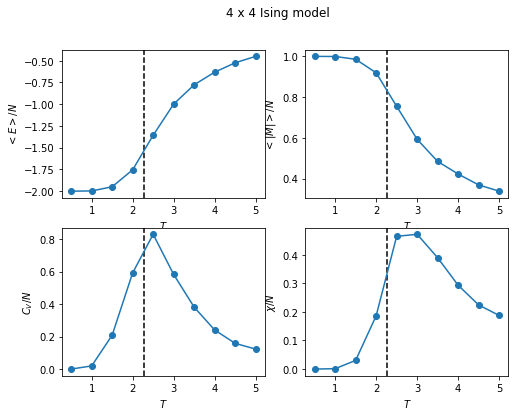

In [14]:
plt.figure(figsize=(8,6))

plt.subplot(221)
plt.axvline(x=Tc, color='k', linestyle='--')
plt.plot(T_list, energy/(1.0*N_spins), 'o-')
plt.xlabel('$T$')
plt.ylabel('$<E>/N$')

plt.subplot(222)
plt.axvline(x=Tc, color='k', linestyle='--')
plt.plot(T_list, mag/(1.0*N_spins), 'o-')
plt.xlabel('$T$')
plt.ylabel('$<|M|>/N$')

plt.subplot(223)
plt.axvline(x=Tc, color='k', linestyle='--')
plt.plot(T_list, specHeat/(1.0*N_spins), 'o-')
plt.xlabel('$T$')
plt.ylabel('$C_V/N$')

plt.subplot(224)
plt.axvline(x=Tc, color='k', linestyle='--')
plt.plot(T_list, susc/(1.0*N_spins), 'o-')
plt.xlabel('$T$')
plt.ylabel('$\chi/N$')

plt.suptitle('%d x %d Ising model' %(L,L))

plt.show()


In the thermodynamic limit, we expect $C_{V}/N$ and $\chi/N$ to diverge at the critical temperature $T_{C}\approx2.269$. On a finite size lattice, however, these will appear as peaks near $T_{C}$.

The code parameters can be adjusted to obtain additional data for larger system sizes $L$ at a larger range of temperatures $T$, as can the MC parameters (e.g. number of thermalization and measurement sweeps) to generate better or worse numerical results.